In [1]:
import Main
import Parser
from Analyser2 import *

In [2]:
modelName = 'dereffye'

In [3]:
# Some PyABC magic to get our set of parameters
from pyabc import (ABCSMC, Distribution, RV, MultivariateNormalTransition)
import scipy as sp
import scipy.stats as st
import tempfile
import os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def model(params):
    return Main.generate_and_analyse(modelName, params)

In [5]:
t1 = Main.generate_and_analyse(modelName, {})
t1

{'parentAngle_mean': 32.34674208132369,
 'parentAngle_variance': 15.825737823482902,
 'length_mean': 0.7942712412170728,
 'length_variance': 0.5950012367186253,
 'verticalOrientation_mean': 51.70272761003072,
 'verticalOrientation_variance': 27.985133791506296,
 'horizontalOrientation_mean': 172.15177981513088,
 'horizontalOrientation_variance': 108.08503816643722,
 'q1_xyz': (4.486912691885426, 28.159871668597432, 5.081878351994339),
 'q2_xyz': (34.15250253977151, 26.176181021547066, 44.0999779040784),
 'q3_xyz': (33.377933315620254, 27.961543022874835, 50.42415775872499),
 'xyz': (35.699191479282405, 81.89858860765308, 50.623387040772855),
 'trunk_length': 10.0,
 'totalBiomass': 405.4273002239391}

In [6]:
metrics = {  'section_1_slash':(10, 100),
             'section_1_slashr':(10, 100),
            'section_1_plus':(0,180),
            'section_1_plusr':(0,180),
             'section_1_decay':(0, 1),
           'section_1_h':(1,20),
             'section_1_w':(0.1, 2),
          }

In [7]:
prior = Distribution(section_1_slash     =RV("uniform", 10, 100),
                     section_1_slashr    =RV("uniform", 10, 100),
                     section_1_plus      =RV("uniform", 0, 180),
                     section_1_plusr      =RV("uniform", 0, 180),
                     section_1_decay     =RV("uniform", 0, 1),
                     section_1_h         =RV("uniform", 1, 20),
                     section_1_w         =RV("uniform", 0.1, 2),
                    )

In [8]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db"))

In [9]:
def gen_av_target(n):
    target = model({})
    for i in range(n):
        print(i)
        new_metrics = model({})
        for (k,v) in new_metrics.items():
            if k[-3:] == 'xyz':
                x,y,z = target[k]
                x += new_metrics[k][0]
                y += new_metrics[k][1]
                z += new_metrics[k][2]
                target[k] = (x,y,z)
            else:
                target[k] += new_metrics[k]

    for (k,v) in target.items():
        if k[-3:] == 'xyz':
            x,y,z = target[k]
            target[k] = (x/n, y/n, z/n)
        else:
            target[k] /= n
            
    return target

In [10]:
target = gen_av_target(20)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [11]:
target

{'parentAngle_mean': 34.184671016463575,
 'parentAngle_variance': 16.654452882750864,
 'length_mean': 0.8339848032779267,
 'length_variance': 0.6247512985545564,
 'verticalOrientation_mean': 57.87617440937854,
 'verticalOrientation_variance': 31.034983105370507,
 'horizontalOrientation_mean': 189.35083061905317,
 'horizontalOrientation_variance': 107.91603016811652,
 'q1_xyz': (17.366958720178133, 29.523574738476462, 29.33705546270884),
 'q2_xyz': (49.24778926036369, 27.553524088722952, 63.833276138104964),
 'q3_xyz': (46.13053744136916, 29.3336231673699, 49.26996691063404),
 'xyz': (51.75707054792728, 85.9935180380357, 65.10167179229751),
 'trunk_length': 10.5,
 'totalBiomass': 425.69866523513593}

In [12]:
mp = 13
me = 0.5

In [13]:
abc = ABCSMC(model, prior, distance)
abc.new(db_path, target)
history = abc.run(minimum_epsilon=me, max_nr_populations=mp)

INFO:History:Start <ABCSMC(id=101, start_time=2019-04-17 23:41:25.671017, end_time=None)>
INFO:Epsilon:initial epsilon is 16.40703365937989
INFO:ABC:t:0 eps:16.40703365937989
INFO:ABC:t:1 eps:11.91824444774505
INFO:ABC:t:2 eps:10.413968196929877
INFO:ABC:t:3 eps:9.350499857428845
INFO:ABC:t:4 eps:7.831823541166611
INFO:ABC:t:5 eps:7.095150186439148
INFO:ABC:t:6 eps:6.311782506166268
INFO:ABC:t:7 eps:5.581824167693418
INFO:ABC:t:8 eps:4.684179137699708
INFO:ABC:t:9 eps:4.210682577454248
INFO:ABC:t:10 eps:3.6629119957683423
INFO:ABC:t:11 eps:3.2599555512631304
INFO:ABC:t:12 eps:2.8173868365087644
INFO:History:Done <ABCSMC(id=101, start_time=2019-04-17 23:41:25.671017, end_time=2019-04-18 00:29:33.129279)>


In [14]:
from pyabc.visualization import plot_kde_1d

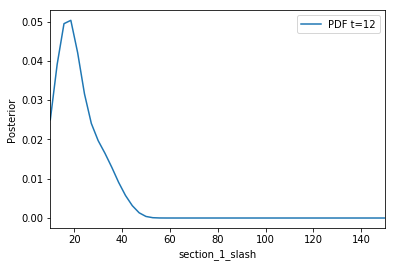

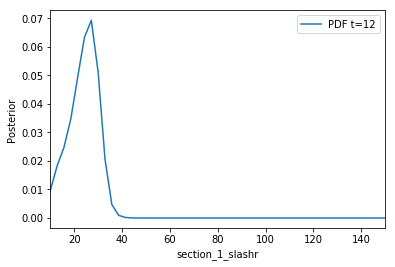

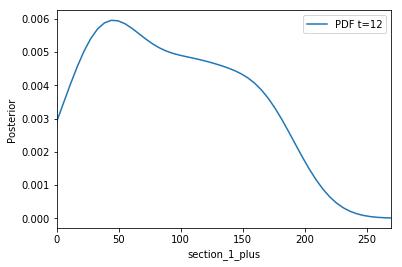

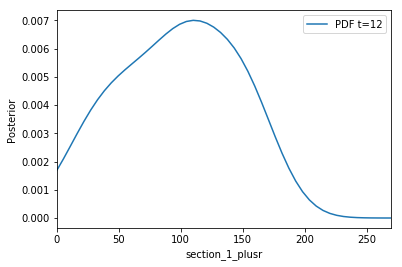

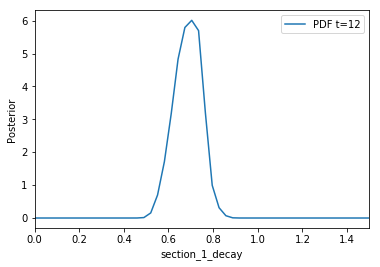

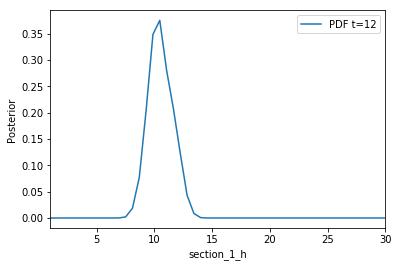

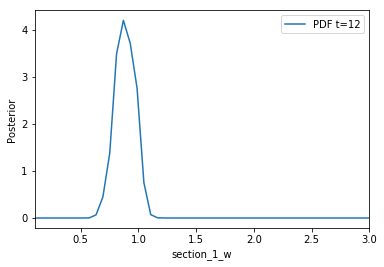

In [15]:
# Visualise results
for k,v in metrics.items():
    fig, ax = plt.subplots()
    for t in range(history.max_t, history.max_t+1):
        df, w = history.get_distribution(m=0, t=t)
        plot_kde_1d(df, w,
                    xmin=v[0], xmax=1.5*v[1],
                    x=k, ax=ax,
                    label="PDF t={}".format(t))
    ax.legend();
    fig.savefig('../../../../Report/images/dereffye_angles/'+k+'_kde')